# HYGRiP machine learning data-set generator
Pablo Ortega (po215@ic.ac.uk), Tong Zhao & Aldo A Faisal

Creates a machine-learning friendly version of the dataset with the specified preprocessing and epoched data.
This way same preprocessing is ensured accross experiments and time is saved.

In [3]:
import h5py
import numpy as np 
import scipy as sp
from scipy import signal

from sklearn.decomposition import FastICA
import warnings

import matplotlib
import matplotlib.pyplot as plt 

from utils.pipelines import *
from utils.plots import *
from utils.ica import *

## Dataset organisation
After generation the data organisation is as follows:
- `measure`
    - `sbj`
        - `condition`
- `attrs`
    - `measure/pipeline/`
    - `epoch_win`
    - `meas_sfreq`

In [4]:
# Load dataset
ds = h5py.File("../data/hygrip.h5", "r")
dataset_name = "../data/hygrip_ml.h5"
ds_ml = {}
ds_ml["attrs"] = {}

In [5]:
# Shared parameters
eeg_fs = 500                        # desired eeg sfreq [Hz]
main_f = 50                         # mains frequency [Hz]
nirs_f = ds.attrs["oxy_sfreq"]      # nirs sfreq [Hz] for filtering purposes 
epoch_win = [-10,30]                # window [s] to create trials with trial onset at t = 0s (same for all pipelines to compute correlations later)

# store in ml_dataset
ds_ml["attrs"] = {}
ds_ml["attrs"]["epoch_win"] = epoch_win
ds_ml["attrs"]["eeg_sfreq"] = eeg_fs
ds_ml["attrs"]["oxy_sfreq"] = ds.attrs["oxy_sfreq"]
ds_ml["attrs"]["dxy_sfreq"] = ds.attrs["dxy_sfreq"]

## Force

Pipeline(FORCE)
	Filter(type=ellip-bandpass, order=2, sfreq[Hz]=50.0, fn[Hz]=[ 0.00,  9.00], gpass[dB]=3, gstop[dB]=20)
	EpochExtractor(t_0[s]=-10, t_end[s]=30)
	Filter(type=ellip-highpass, order=3, sfreq[Hz]=50.0, fn[Hz]= 0.00, gpass[dB]=1, gstop[dB]=60)
	LabelGatherer()
	VCconverter()



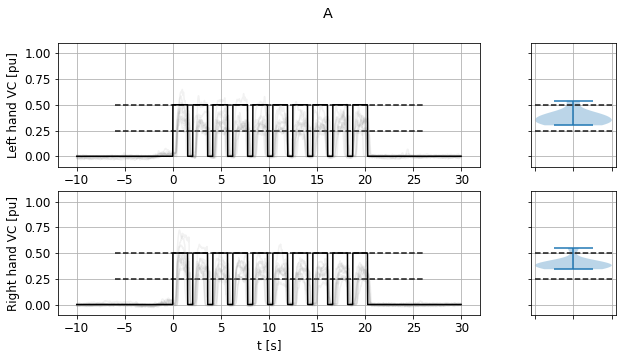

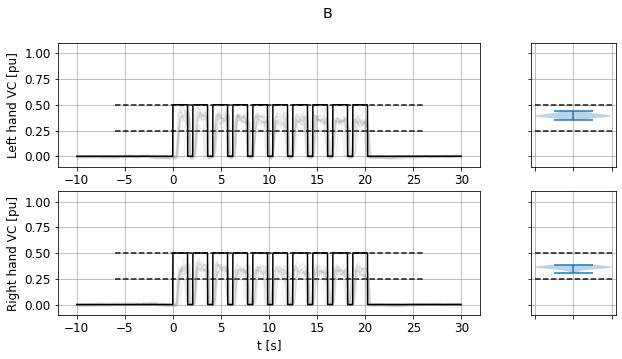

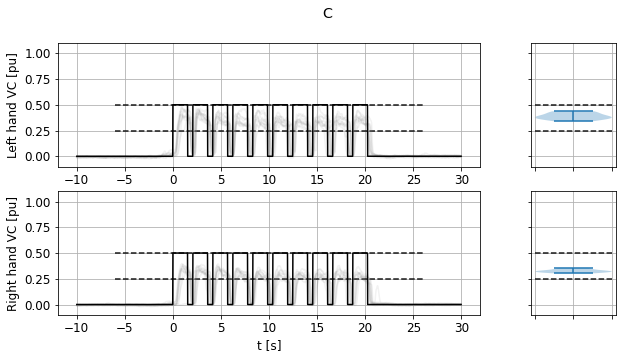

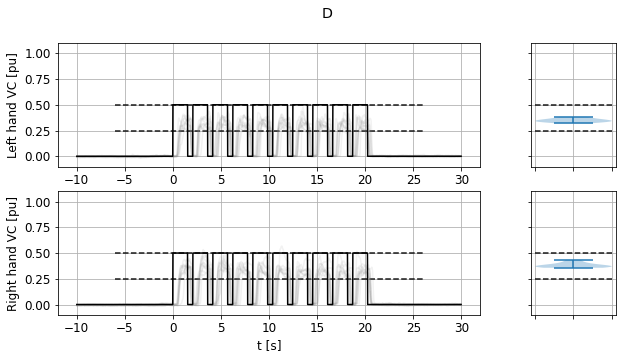

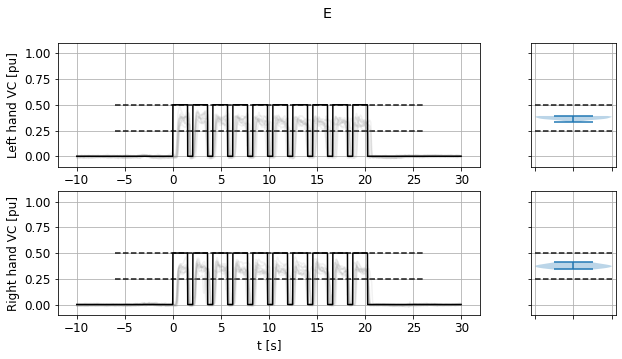

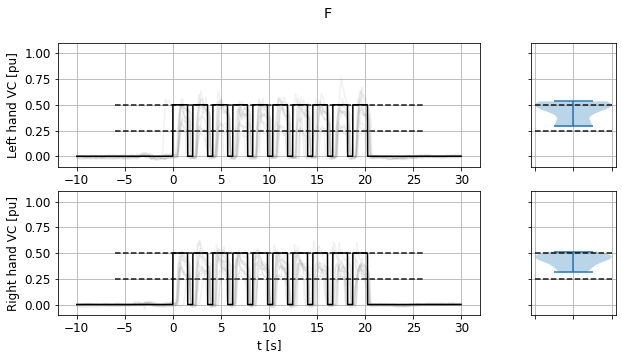

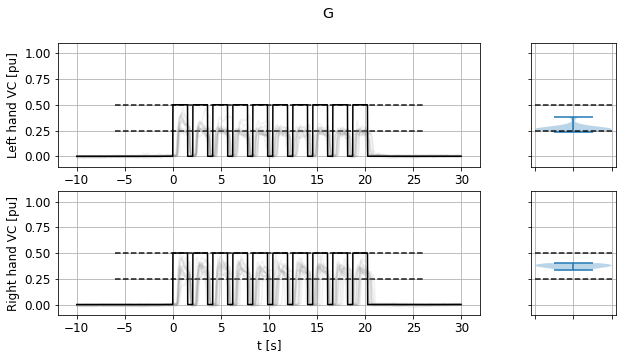

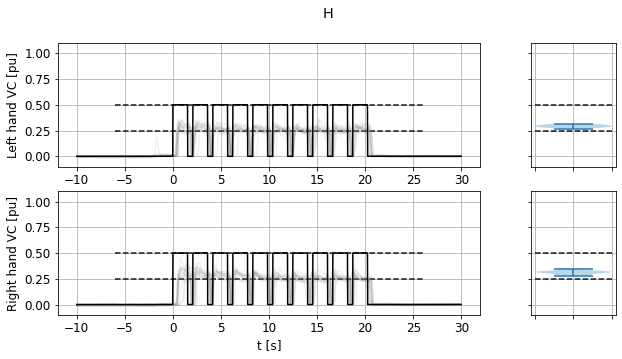

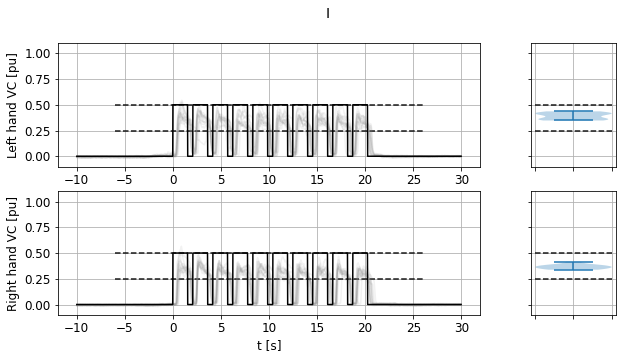

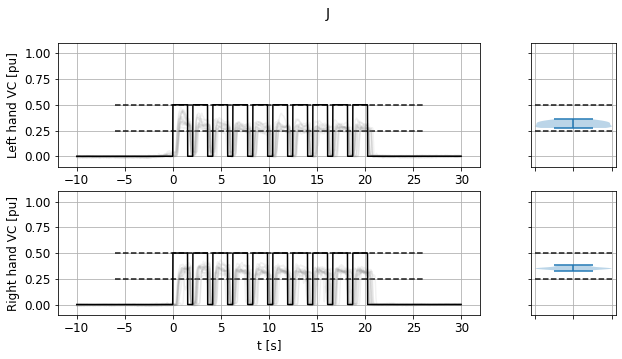

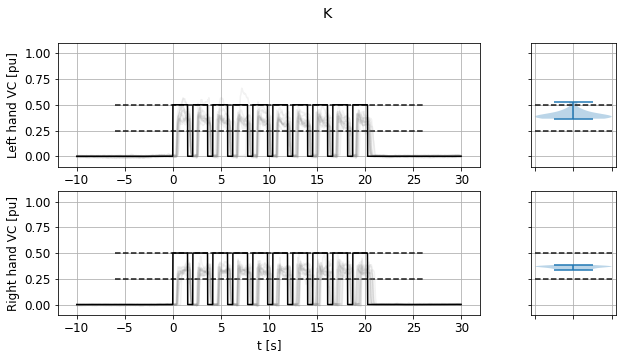

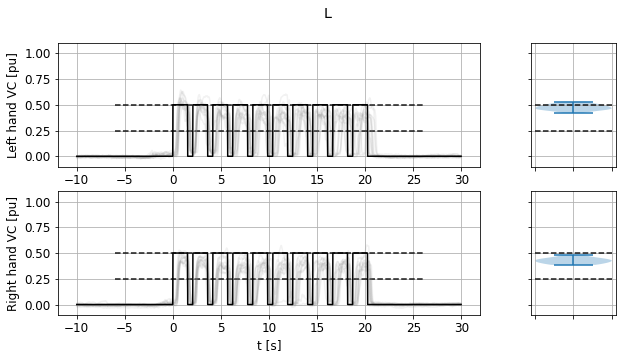

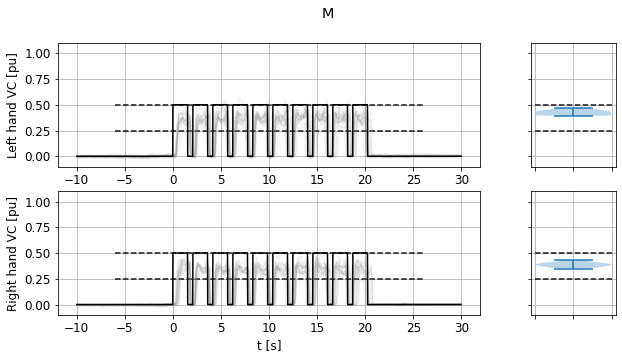

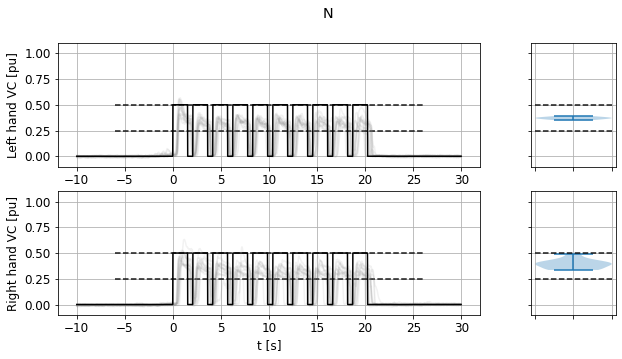

In [6]:
frc_pipe = Pipeline(
    [
        Filter([[1e-4, 9], [1e-5, 14]], ds.attrs["frc_sfreq"], gpass=3, gstop=20, filttype="ellip"),
        EpochExtractor(epoch_win),
        Filter([1e-3, 1e-4], ds.attrs["frc_sfreq"], gpass=1, gstop=60, filttype="ellip"),
        LabelGatherer(),                     
        VCconverter(),
    ],
    name="FORCE"
)

print(frc_pipe)

ds_ml["frc"] = {}
ds_ml["attrs"]["frc_sfreq"] = ds.attrs["frc_sfreq"]
ds_ml["frc"]["pipe"] = frc_pipe.__repr__()

for sbj in ds.keys():
    print(f"Processing {sbj}", end="\r")
    force, frc_evts, frc_fs = frc_pipe(ds[sbj+"/frc"], ds[sbj+"/frc"].attrs["events"], ds.attrs["frc_sfreq"], mvc=ds[sbj+"/frc"].attrs["MVC"])
    fig, ax = plot_force(force, frc_evts, frc_fs, plot_task=True)
    fig.suptitle(sbj)
    ds_ml["frc"][sbj] = {}
    ds_ml["frc"][sbj]["1"] = force[0:1]
    ds_ml["frc"][sbj]["2"] = force[1:2]

In [28]:
# CUSTOM CODE
#
# customized version of the get_task function from the pipelines.py file
# this function generates a vector of square-wave bursts that take the value 0
# whenever the audio signal is silent, and 0.375 (the average of 0.25 and 0.5)
# whenever the audio signal is on. 0.375 was chosen because it is the median
# of the range in which subjects were instructed to keep their squeeze pressure.

def get_task_regression(force, evts, fs, tup=1.55, tdown=0.55, repeats=10):
    """ Builds task starting at times indicated in events
    :param force: (array) force data
    :param evts: (array) force events
    :param fs: (float) force sampling frequency [Hz]
    :param tup: (float) contraction time [s]
    :param tdown: (float) relaxation time [s]
    :param repeats: (int) number of repetitions per trial
    :return: (array) task
    """
    from math import sin, pi, sqrt
    task = np.zeros((1, force.shape[-1]))
    signal_range = (range(1,int(tup*fs))/(tup*fs))*pi
    signal = [.375*sin(x)/sqrt((sin(x))**2 + 0.3) for x in signal_range]
    trial = np.concatenate([np.array([signal]),np.zeros((1,int(tdown*fs)))], -1)
    trial = [trial for i in range(repeats)]
    trial = np.concatenate(trial, -1)
    n = trial.shape[-1]
    times = np.arange(force.shape[-1]) / fs
    for i in range(evts.shape[0]):
        if evts[i,1] != -1:
            i0 = np.argmin(np.abs(times-evts[i,0]))
            task[:,i0:i0+n] = trial
        tasks = []
    for i in range(10):
        for t in task[0]:
            tasks.append(t)
    tasks = tasks
    return tasks

In [456]:
# CUSTOM CODE
#
# This cell produces an extra data-frame containing the signal for the squeeze task.
# It will be used to help de-trend the force data before building time-series models
# for benchmarking.
force, frc_evts, frc_fs = frc_pipe(ds["A"+"/frc"], ds["A"+"/frc"].attrs["events"], ds.attrs["frc_sfreq"], mvc=ds[sbj+"/frc"].attrs["MVC"])
tsk = get_task_regression(force, frc_evts[0,0:1], frc_fs)

In [457]:
import pandas as pd
pd.DataFrame(tsk).to_csv('task_signals.csv', sep='\t')

## NIRS

Pipeline(NIRS)
	Joiner(axis=-2)
	Filter(type=ellip-lowpass, order=7, sfreq[Hz]=12.5, fn[Hz]= 0.25, gpass[dB]=1, gstop[dB]=60)
	EpochExtractor(t_0[s]=-10, t_end[s]=30)
	LabelGatherer()
	HbConverter(tbound[s]=[4, 5], DPF[1]=[5.98 7.54], SD[cm]=3.0, exc[cm^-1 mol^-1]=[1486.5865 3843.707  2526.391  1798.643 ])



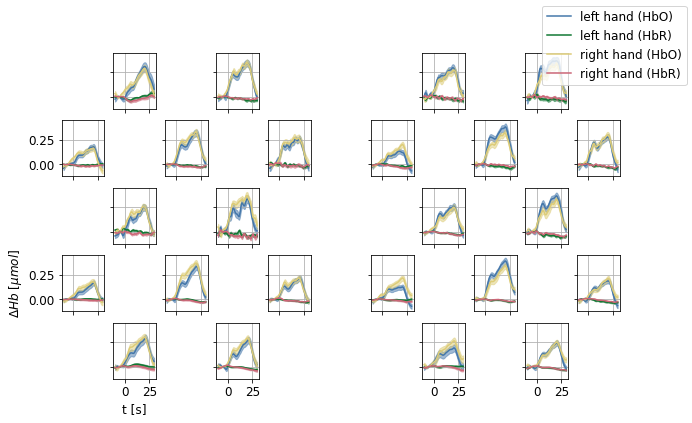

In [29]:
nirs_pipe = Pipeline(
    [
        Joiner(axis=-2),
        Filter([0.25, 0.3], ds.attrs["oi1_sfreq"], gpass=1, gstop=60, filttype="ellip"),
        EpochExtractor(epoch_win),
        LabelGatherer(),                     
        HbConverter(ds.attrs["nirs_DPF"], ds.attrs["nirs_SD"], ds.attrs["nirs_exc"], tbound=[4,5])
    ],
    name="NIRS"
)

print(nirs_pipe)

ds_ml["nirs"] = {}
ds_ml["nirs"]["pipe"] = nirs_pipe.__repr__()

nirs = []
for sbj in ds.keys():
    x, nirs_evts, nirs_fs = nirs_pipe(ds[sbj+"/oi1"], ds[sbj+"/oi1"].attrs["events"], ds.attrs["oi1_sfreq"], y=ds[sbj+"/oi2"]) 
    nirs.append(x)
    ds_ml["nirs"][sbj] = {}
    ds_ml["nirs"][sbj]["1"] = x[0:1]
    ds_ml["nirs"][sbj]["2"] = x[1:2]
    
nirs = np.concatenate(nirs, axis=1)
fig, ax = plot_hb(nirs, nirs_evts, nirs_fs, ds.attrs["scalp_chan_grid"])
fig.legend()

## EEG
__NOTES__:<br>
- Some trials in electrical measures have an artefact from -5s to -1s to the start of the trial and from 21 s at the end to 25 s since at this times subjects were allowed to relax.
- The EEG also has electrical noise leaking from the NIRS system LED's sampling at $12.5~$Hz.

In [30]:
# Stream A : remove electric noise & removes EOG
ica_fs = 25
ica_mode = "per_condition"
ica_filter = Filter([[1, 3],[0.5, 4]], ica_fs, gpass=3, gstop=30, filttype="butter")
eeg_pipe_a = Pipeline(
    [
        Downsampler(ds.attrs["eeg_sfreq"], eeg_fs)
    ]
    + [Filter([main_f*(1+i), Q], eeg_fs, filttype="notch") for i, Q in enumerate([80,100])]
    + [Filter([nirs_f*(1+i), Q], eeg_fs, filttype="notch") for i, Q in enumerate([100]*9)] 
    + [ 
        Filter([1, 0.5], eeg_fs, gpass=3, gstop=30, filttype="butter"),
        EpochExtractor(epoch_win),
        LabelGatherer(),
        IcaReconstructor(
            ica_fs, max_components=1, threshold=.3, prefilter=ica_filter, max_iter=1000, tolerance=1e-4, 
            tlim=[-1,21], mode=ica_mode, standarize=True
        ),
      ],
    name="EEGa"
)

# Stream B : removes EMG and electrical artefacts at beginning and end
ica_fs = 125
ica_filter = Filter([1,0.5], ica_fs, gpass=3, gstop=30, filttype="butter")
eeg_pipe_b = Pipeline(
    [
        IcaReconstructor(
            ica_fs, max_components=3, threshold=1e-4, prefilter=ica_filter, max_iter=1000, tolerance=1e-4,
            tlim=[-5,0], rec_tlim=[-5,0], mode=ica_mode, standarize=True
        ),
        IcaReconstructor(
            ica_fs, max_components=3, threshold=1e-4, prefilter=ica_filter, max_iter=1000, tolerance=1e-4,
            tlim=[20,25], rec_tlim=[20,25], mode=ica_mode, standarize=True
        ),
        IcaReconstructor(
            ica_fs, max_components=2, threshold=1e-4, prefilter=ica_filter, max_iter=1000, tolerance=1e-4,
            tlim=[-5,25], mode=ica_mode, standarize=True
        )
    ],
    name="EEGb"
)

ref_pipe = Pipeline(
    [
        EpochExtractor(epoch_win),
        LabelGatherer() 
    ],
    name="REF"
)

print(eeg_pipe_a)
print(eeg_pipe_b)
print(ref_pipe)

ds_ml["eeg"] = {}
ds_ml["eeg"]["pipe"] = eeg_pipe_a.__repr__() + eeg_pipe_b.__repr__()


eeg = []
for sbj in ds.keys():
    print(f"Processing {sbj}a: ")
    ref, ref_evts, ref_fs = ref_pipe(
        ds[sbj+"/eog"], ds[sbj+"/eog"].attrs["events"], ds.attrs["eog_sfreq"]
    )
    x, eeg_evts, eeg_fs = eeg_pipe_a(
        ds[sbj+"/eeg"], ds[sbj+"/eeg"].attrs["events"], ds.attrs["eeg_sfreq"], 
        ref=ref, ref_evts=ref_evts, ref_fs=ref_fs
    )
    print(f"Processing {sbj}b: ")
    ref, ref_evts, ref_fs = ref_pipe(
        ds[sbj+"/emg"], ds[sbj+"/emg"].attrs["events"], ds.attrs["emg_sfreq"]
    )
    x, eeg_evts, eeg_fs = eeg_pipe_b(
        x, eeg_evts, eeg_fs, 
        ref=ref, ref_evts=ref_evts, ref_fs=ref_fs
    )
    ds_ml["eeg"][sbj] = {}
    ds_ml["eeg"][sbj]["1"] = x[0:1]
    ds_ml["eeg"][sbj]["2"] = x[1:2]
    
    eeg.append(x)
    print()
    
eeg = np.concatenate(eeg, axis=1)
print("@done")

Pipeline(EEGa)
	Downsampler(sfreq_in[Hz]=1000.0, sfreq_out[Hz]=1000, axis=-1, thres=13)
	Filter(type=notch-bandstop, sfreq[Hz]=1000, fn0[Hz]= 50.00, Q[1]=80)
	Filter(type=notch-bandstop, sfreq[Hz]=1000, fn0[Hz]= 100.00, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=1000, fn0[Hz]= 12.50, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=1000, fn0[Hz]= 25.00, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=1000, fn0[Hz]= 37.50, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=1000, fn0[Hz]= 50.00, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=1000, fn0[Hz]= 62.50, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=1000, fn0[Hz]= 75.00, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=1000, fn0[Hz]= 87.50, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=1000, fn0[Hz]= 100.00, Q[1]=100)
	Filter(type=notch-bandstop, sfreq[Hz]=1000, fn0[Hz]= 112.50, Q[1]=100)
	Filter(type=butter-highpass, order=5, sfreq[Hz]=1000, fn[Hz]= 1.00, gpass[dB]=3, gstop[dB]=30)
	EpochExtractor(t_0[s]=-10, t_end

/home/oliver/Data/hygrip/hygrip-master/utils/plots.py:373: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[r, c].pcolormesh(tnew, fnew, Snew, cmap=plt.get_cmap("coolwarm"),vmax=kwargs["scale"][1], vmin=kwargs["scale"][0])


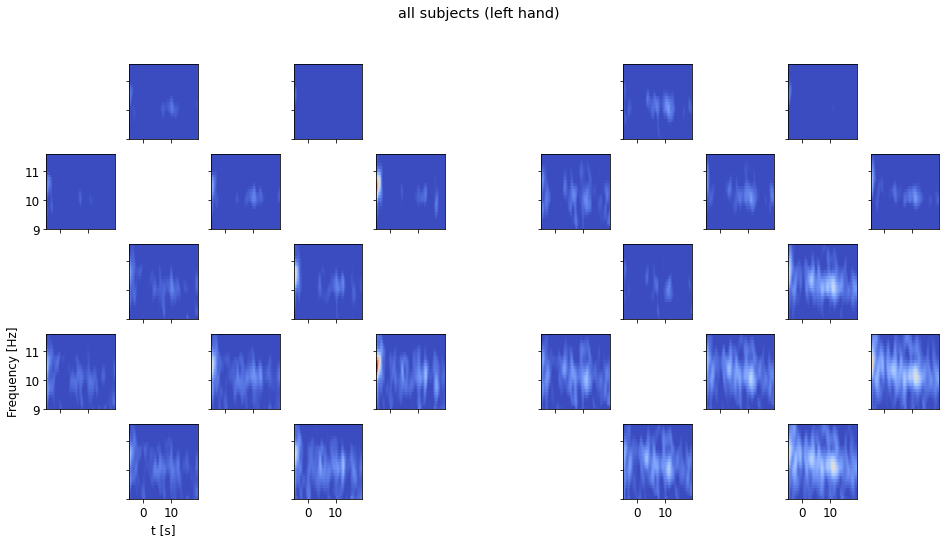

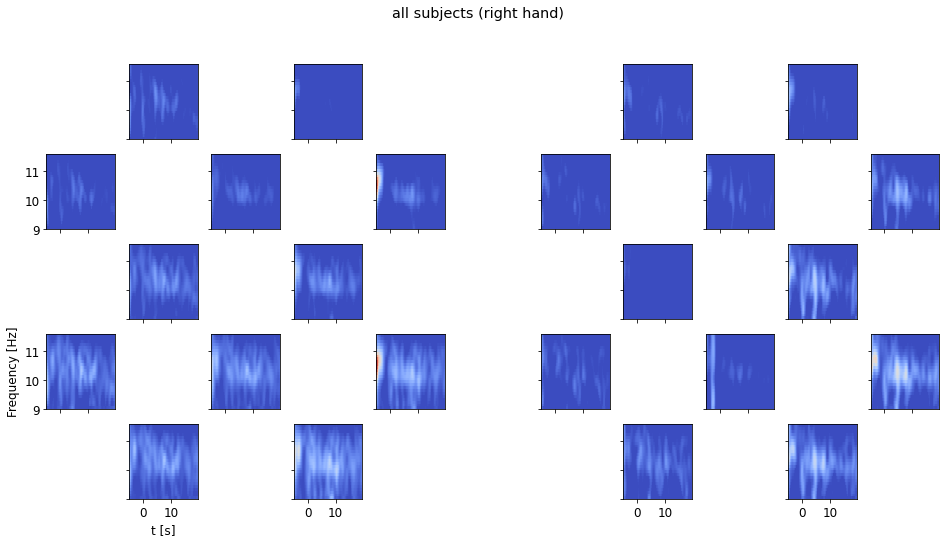

In [31]:
scaling = "density"
kb = "mu"
bands = {"delta":[1,4], "delta+theta":[1,8], "theta":[4,8], "mu":[9,12], "mu+beta": [6,30], "beta":[12,30], "gamma":[30, 60], "high-gamma":[75, 125]}
w = {"delta":3, "mu":3, "beta":2, "gamma":2, "high-gamma":1}
band = bands[kb]
window = signal.windows.hann(int(eeg_fs*w[kb]))
noverlap = window.shape[0] / 1.1

for hand in ["left", "right"]:
    fig, ax = plot_eeg(
        eeg, eeg_evts, eeg_fs, ds.attrs["scalp_chan_grid"], hand, tlim=[-5,20], flim=band, 
        mode="specgram", scaling=scaling, window=window, noverlap=noverlap, scale=[11000,60000]
    )
    fig.suptitle(f"all subjects ({hand} hand)")

## EMG

Pipeline(EMG)
	Downsampler(sfreq_in[Hz]=1000.0, sfreq_out[Hz]=500, axis=-1, thres=13)
	Filter(type=butter-highpass, order=39, sfreq[Hz]=500, fn[Hz]= 119.45, gpass[dB]=2, gstop[dB]=40)
	EpochExtractor(t_0[s]=-10, t_end[s]=30)
	LabelGatherer()

Processing N
@done


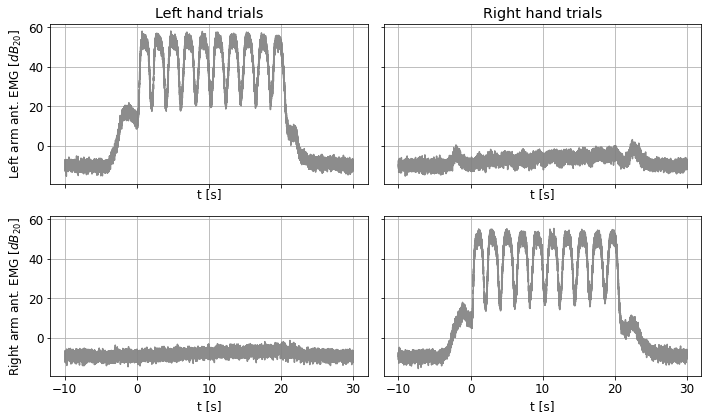

In [7]:
emg_fs = eeg_fs
emg_pipe = Pipeline(
    [
        Downsampler(ds.attrs["emg_sfreq"], emg_fs),
        Filter([120, 110], eeg_fs, gpass=2, gstop=40, filttype="butter"),
        EpochExtractor(epoch_win),
        LabelGatherer(),
    ],
    name="EMG"
)

print(emg_pipe)

ds_ml["emg"] = {}
ds_ml["emg"]["pipe"] = emg_pipe.__repr__()
ds_ml["attrs"]["emg_sfreq"] = emg_fs

emg = []
for sbj in ds.keys():
    print(f"Processing {sbj}", end="\r")
    x, emg_evts, emg_fs = emg_pipe(
        ds[sbj+"/emg"], ds[sbj+"/emg"].attrs["events"], ds.attrs["emg_sfreq"]
    )
    ds_ml["emg"][sbj] = {}
    ds_ml["emg"][sbj]["1"] = x[0:1]
    ds_ml["emg"][sbj]["2"] = x[1:2]
    
    emg.append(x)
    
emg = np.concatenate(emg, axis=1)
fig, ax = plot_emg_power(emg, emg_evts, emg_fs, face="ant", st_err=False, tbound=[0,0.5])
print("\n@done")

(1, 10, 4, 20000)

### EOG

Pipeline(EOG)
	Downsampler(sfreq_in[Hz]=1000.0, sfreq_out[Hz]=50, axis=-1, thres=13)
	Filter(type=butter-highpass, order=8, sfreq[Hz]=50, fn[Hz]= 0.97, gpass[dB]=2, gstop[dB]=40)
	EpochExtractor(t_0[s]=-5, t_end[s]=25)
	LabelGatherer()



Text(0.5, 0.98, 'all subjects')

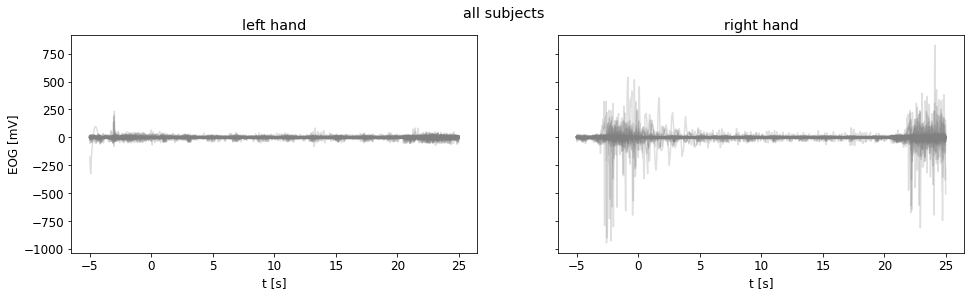

In [16]:
eog_fs = 50
eog_pipe = Pipeline(
    [
        Downsampler(ds.attrs["eog_sfreq"], eog_fs),
        Filter([1, 0.5], eog_fs, gpass=2, gstop=40, filttype="butter"),
        EpochExtractor([-5,25]),
        LabelGatherer()
    ],
    name="EOG"
)
print(eog_pipe)

ds_ml["eog"] = {}
ds_ml["eog"]["pipe"] = eog_pipe.__repr__()
ds_ml["attrs"]["eog_sfreq"] = eog_fs

eog = []
for sbj in ds.keys():
    x, eog_evts, eog_fs = eog_pipe(ds[sbj+"/eog"], ds[sbj+"/eog"].attrs["events"], ds.attrs["eog_sfreq"])
    ds_ml["eog"][sbj] = {}
    ds_ml["eog"][sbj]["1"] = x[0:1]
    ds_ml["eog"][sbj]["2"] = x[1:2]
    eog.append(x)
    
eog = np.concatenate(eog, axis=1)
fig, ax = plot_eog(eog, eog_evts, eog_fs)
fig.suptitle("all subjects")


In [20]:
ds_ml["eog"]["A"]["1"].shape

(1, 10, 1, 1500)

### Breath

In [ ]:
brt_pipe = Pipeline(
    [
        Filter([5, 6], ds.attrs["brt_sfreq"], gpass=3, gstop=30, filttype="butter"),
        EpochExtractor(epoch_win),
        LabelGatherer()
    ],
    name="BREATH"
)
print(brt_pipe)

ds_ml["brt"] = {}
ds_ml["brt"]["pipe"] = brt_pipe.__repr__()
ds_ml["attrs"]["eog_sfreq"] = ds.attrs["brt_sfreq"]

brt = []
for sbj in ds.keys():
    x, brt_evts, brt_fs = brt_pipe(ds[sbj+"/brt"], ds[sbj+"/brt"].attrs["events"], ds.attrs["brt_sfreq"])
    ds_ml["eog"][sbj] = {}
    ds_ml["eog"][sbj]["1"] = x[0:1]
    ds_ml["eog"][sbj]["2"] = x[1:2]
    brt.append(x)
brt = np.concatenate(brt, axis=1)
fig, ax = plot_brt(brt, brt_evts, brt_fs)
fig.suptitle("all subjects");

# Save machine learning dataset

In [ ]:
print(ds_ml.keys())
print("frc:", ds_ml["frc"].keys())
print("nirs:", ds_ml["nirs"].keys())
print("eeg:", ds_ml["eeg"].keys())
print("emg:", ds_ml["emg"].keys())
print("eog:", ds_ml["eog"].keys())
print("brt:", ds_ml["brt"].keys())
print(ds_ml["attrs"])

In [ ]:
with h5py.File(dataset_name, "w") as h5fid:
    # Copy attributes
    for k in ds_ml["attrs"]:
        h5fid.attrs[k] = ds_ml["attrs"][k]
    
    for k_meas in ds_ml.keys():
        print(k_meas)
        if k_meas != "attrs":
            meas = h5fid.create_group(k_meas)
            for k_sbj in ds_ml[k_meas].keys():
                if k_sbj == "pipe":
                    meas.attrs["pipe"] = ds_ml[k_meas]["pipe"]
                else:
                    sbj = h5fid.create_group(f"{k_meas}/{k_sbj}")
                    print(k_sbj)
                    for ses in ds_ml[k_meas][k_sbj].keys():
                        dset = h5fid.create_dataset(f"/{k_meas}/{k_sbj}/{ses}", data=ds_ml[k_meas][k_sbj][ses])

In [ ]:
ds2 = h5py.File("./hygrip_ml.h5", "r")
def printattr(name, obj):
    print(name)
ds2.visititems(printattr)

In [ ]:
ds2.attrs.keys()

In [ ]:
ds2["nirs/N/1"].shape

In [1]:
make_scalp_grid(ds1.attrs["scalp_chan_grid"], [5,5])

NameError: name 'make_scalp_grid' is not defined